## Librerias

In [1]:
import numpy as np
import torch 
import time
import matplotlib.pyplot as plt
import pickle
import os
import gdown
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

## Lectura de datos

In [2]:
path = "D:/codigos/Autoencoder/ZTF/Dataset/td_ztf_stamp_17_06_20-002.pkl"
if not os.path.isfile(path):
    url = 'https://drive.google.com/drive/folders/1vqfoxF-KyMNnLxABZZ_kb76DrUrixEud'
    output="D:/codigos/Autoencoder/ZTF/Dataset"
    gdown.download_folder(url,output, quiet=False)

In [5]:
path = "D:/codigos/Autoencoder/ZTF/Dataset/datosAutoencoder.npy"
if not os.path.isfile(path):
    with open('D:/codigos/Autoencoder/ZTF/Dataset/td_ztf_stamp_17_06_20-002.pkl', 'rb') as f:
        data = pickle.load(f)
    print(data.keys())

dict_keys(['Train', 'Validation', 'Test'])


## Exploracion

In [6]:
print("Dimension, tipo, llaves")
print(np.shape(data["Train"]),type(data["Train"]),data["Train"].keys())

Dimension, tipo, llaves
() <class 'dict'> dict_keys(['images', 'labels', 'features'])


In [7]:
print("Cantidad de muestras")
print(np.shape(data["Train"]["labels"]))
print(np.shape(data["Validation"]["labels"]))
print(np.shape(data["Test"]["labels"]))
print("Dimensiones")
print(np.shape(data["Train"]["images"]))
print(np.shape(data["Validation"]["images"]))
print(np.shape(data["Test"]["images"]))

Cantidad de muestras
(72710,)
(500,)
(500,)
Dimensiones
(72710, 63, 63, 3)
(500, 63, 63, 3)
(500, 63, 63, 3)


## Procesamiento
Recorte a 21 x 21

In [8]:
datatrain=np.zeros([len(data["Train"]["images"]),21,21,3])
dataval=np.zeros([len(data["Validation"]["images"]),21,21,3])
datatest=np.zeros([len(data["Test"]["images"]),21,21,3])

for id,muestra in enumerate(data["Train"]["images"]):
    datatrain[id]=muestra[ 21:42 , 21:42 ]
for id,muestra in enumerate(data["Validation"]["images"]):
    dataval[id]=muestra[ 21:42 , 21:42 ]
for id,muestra in enumerate(data["Test"]["images"]):
    datatest[id]=muestra[ 21:42 , 21:42 ]

In [68]:
datatrain_tensor = torch.Tensor(datatrain)
datatrain_tensor = datatrain_tensor.permute(0, 3, 1, 2)
my_datatrain = TensorDataset(datatrain_tensor,torch.Tensor(data["Train"]["labels"]))


In [69]:
dataval_tensor = torch.Tensor(dataval)
dataval_tensor = dataval_tensor.permute(0, 3, 1, 2)
my_dataval = TensorDataset(dataval_tensor,torch.Tensor(data["Validation"]["labels"]))

## Funciones de entrenamiento

In [99]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

def train_model(
    model,
    criterioy,
    criteriox,
    train_dataset,
    val_dataset,
    num_epoch,
    batch_size,
    lr,
    use_gpu=False
):
    if use_gpu:
        model.cuda()


    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)
    num_total_steps=len(train_loader)
    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": []
    }


    t0 = time.perf_counter()

    for epoch in range(num_epoch):
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_acc_count=0
        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            print(f"\rEpoch {epoch + 1}/{num_epoch} - Batch {i}/{len(train_loader)}", end="")
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            # Predicción
            x_reconstructed, y_predicted = model(x_batch)
            if use_gpu:
                y_batch = y_batch.type(torch.LongTensor).cuda()
            else:
                y_batch = y_batch.type(torch.LongTensor)
            # y_batch = y_batch.reshape(-1, 1)

            # Cálculo de loss
           
            loss_y = criterioy(y_predicted,y_batch)
            loss_x = criteriox(x_reconstructed, x_batch)
           

            loss=loss_y*0.05+loss_x*0.95

            # Actualización de parámetros
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            cumulative_train_loss += loss.item()

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            train_acc_count += y_batch.shape[0]

            cumulative_train_corrects += (y_batch == class_prediction).sum().item()
        train_acc=cumulative_train_corrects / train_acc_count
        train_loss=cumulative_train_loss/num_total_steps
        print(f"Epoch [{epoch+1}/{num_epoch}],  Loss:{train_loss:.4f}, acc train: {train_acc:.4f}")

        # Evaluación del modelo
        model.eval()
        with torch.no_grad():
            val_acc_count=0
            cumulative_val_corrects=0
            for x_val, y_val in val_loader:
                if use_gpu:
                    x_val = x_val.cuda()
                    y_val = y_val.cuda()

                x_reconstructed, y_predicted = model(x_val)
                if use_gpu:

                    y_val = y_val.type(torch.LongTensor).cuda()
                else:
                    y_val = y_val.type(torch.LongTensor).cuda()
                class_prediction = torch.argmax(y_predicted, axis=1).long()
                val_acc_count += y_val.shape[0]
                cumulative_val_corrects += (y_val == class_prediction).sum().item()
                # Cálculo de loss
                loss_y_val = criterioy(y_predicted, y_val)
                loss_x_val = criteriox(x_reconstructed, x_val)

                loss_val=loss_y_val*0.05+loss_x_val*0.95

        val_acc=cumulative_val_corrects / val_acc_count
        val_loss=loss_val.item()

        print(f"\t, Loss:{val_loss:.4f}, acc val: {val_acc:.4f}")

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)
    model.cpu()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    return curves

## Autoencoder

In [2]:
class AutoEncoderV5(nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = nn.Sequential(

            # Bloque 1
            # [3x21x21]
            nn.ZeroPad2d(3),
            # [3x27x27]
            nn.Conv2d(3, 16, kernel_size=4, padding="same"),
            nn.ReLU(),
            # [16, 24, 24]
            nn.Conv2d(16, 32, kernel_size=3, padding="same"),
            nn.ReLU(),
            # [32, 24, 24]
            nn.AvgPool2d(kernel_size=2),
            # [32, 12, 12]

            # Bloque 2
            nn.Conv2d(32, 32, kernel_size=3, padding="same"),
            nn.ReLU(),
            # [32, 12, 12]
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.ReLU(),
            # [64, 12, 12]
            nn.AvgPool2d(kernel_size=2),
            # [64, 6, 6]

            # Bloque 3
            nn.Conv2d(64, 64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.ReLU(),
            # [128, 6, 6]
            nn.AvgPool2d(kernel_size=2),
            # [128, 3, 3]

            # Bloque 4
            nn.Conv2d(128, 128, kernel_size=3, padding="same"),
            nn.ReLU(),
            # [128, 3, 3]
            nn.AvgPool2d(kernel_size=2),
            # [128, 1, 1]   
        )
        self.decoder = nn.Sequential(
            # BLoque 1
            # [128, 1, 1]
            nn.ConvTranspose2d(128, 64, 2,stride=1),
            nn.ReLU(),
            # [64, 2, 2]

            # BLoque 2
            nn.ConvTranspose2d(64, 64, 3,stride=2),
            nn.ReLU(),
            # [64, 5, 5]
            nn.ConvTranspose2d(64, 32, 1,stride=1),
            nn.ReLU(),
            # [32, 5, 5]

            # Bloque 3
            nn.ConvTranspose2d(32, 32, 2,stride=2),
            nn.ReLU(),
            # [32, 10, 10]
            nn.ConvTranspose2d(32, 32, 1,stride=1),
            nn.ReLU(),
            # [32, 10, 10]

            # BLoque 4
            nn.ConvTranspose2d(32, 16, 3,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 1,stride=1),
            nn.ReLU(),
            # Bloque 5
            nn.ConvTranspose2d(16, 3, 1,stride=1),
            nn.ReLU(),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.8),
            nn.Linear(128,64),
            nn.ReLU(),
            # Rotation concat
            # cyclic pooling
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,5),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
            encoder = self.encoder(x)
            decoder = self.decoder(encoder)
            classification = self.classifier(encoder)
            return decoder,classification

## Entrenamiento
### Esto es de prueba de funcionamiento, el verdadero se encuentra en el script de entrenamiento

In [102]:
model=AutoEncoderV5()
num_epoch=3
lr=1e-4
batch=64
criterio1=nn.CrossEntropyLoss()
criterio2=nn.MSELoss()
# def train_model(
#     model,
#     criterioy,
#     criteriox,
#     train_dataset,
#     val_dataset,
#     num_epoch,
#     batch_size,
#     lr,
#     use_gpu=False

history=train_model(model,criterio1,criterio2,my_datatrain,my_dataval,num_epoch,batch,lr,False)

Epoch 1/3 - Batch 1136/1137Epoch [1/3], Loss:0.2889, acc train: 0.5085
	, Loss:0.2180, acc val: 0.6500
Epoch 2/3 - Batch 1136/1137Epoch [2/3], Loss:0.2221, acc train: 0.6774
	, Loss:0.1961, acc val: 0.7060
Epoch 3/3 - Batch 1136/1137Epoch [3/3], Loss:0.2040, acc train: 0.7143
	, Loss:0.1860, acc val: 0.7160
Tiempo total de entrenamiento: 470.1131 [s]


## 

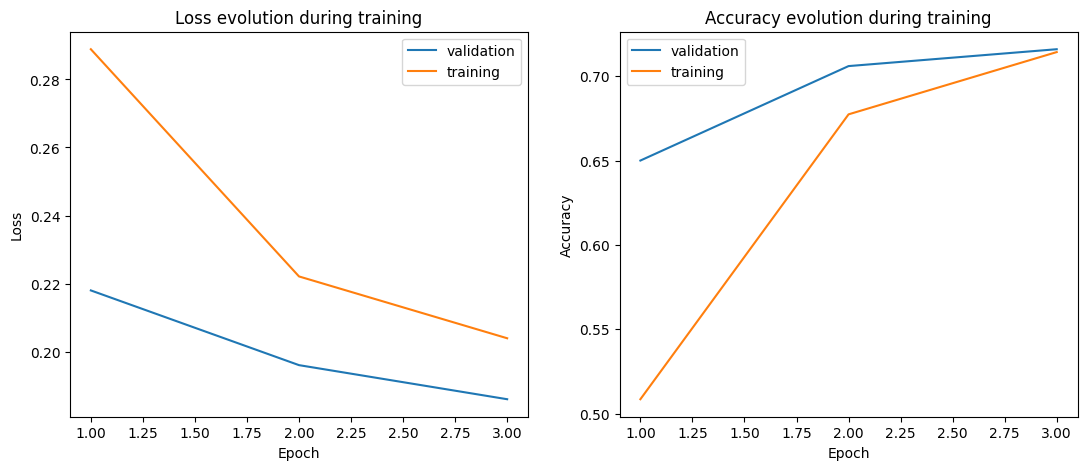

In [103]:
show_curves(history)

## Resultados

In [9]:
datatest_tensor = torch.Tensor(datatest)
datatest_tensor = datatest_tensor.permute(0, 3, 1, 2)
my_datatest= TensorDataset(datatest_tensor,torch.Tensor(data["Test"]["labels"]))

In [10]:
model = AutoEncoderV5()
# model = torch.load("D:\codigos\Autoencoder\ZTF\Autoencoder\modelos entrenados\AutoencoderClasificador10.pth")
# model.eval()
model.load_state_dict(torch.load('D:\codigos\Autoencoder\ZTF\Autoencoder\modelos entrenados\AutoencoderDefinitivo4.pth'))

<All keys matched successfully>

In [11]:
test_loader = torch.utils.data.DataLoader(my_datatest, batch_size=len(my_datatest), shuffle=False, pin_memory=False)
model.eval()
with torch.no_grad():
    for x_test,y_test in test_loader:
        # print(np.shape(x_test))
        # print(np.shape(y_test))

        x_reconstructed, y_predicted = model(x_test)

c:\Users\nicoi\MyEnv\inteligencia\lib\site-packages\torch\nn\modules\conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:896.)
  return F.conv2d(input, weight, bias, self.stride,


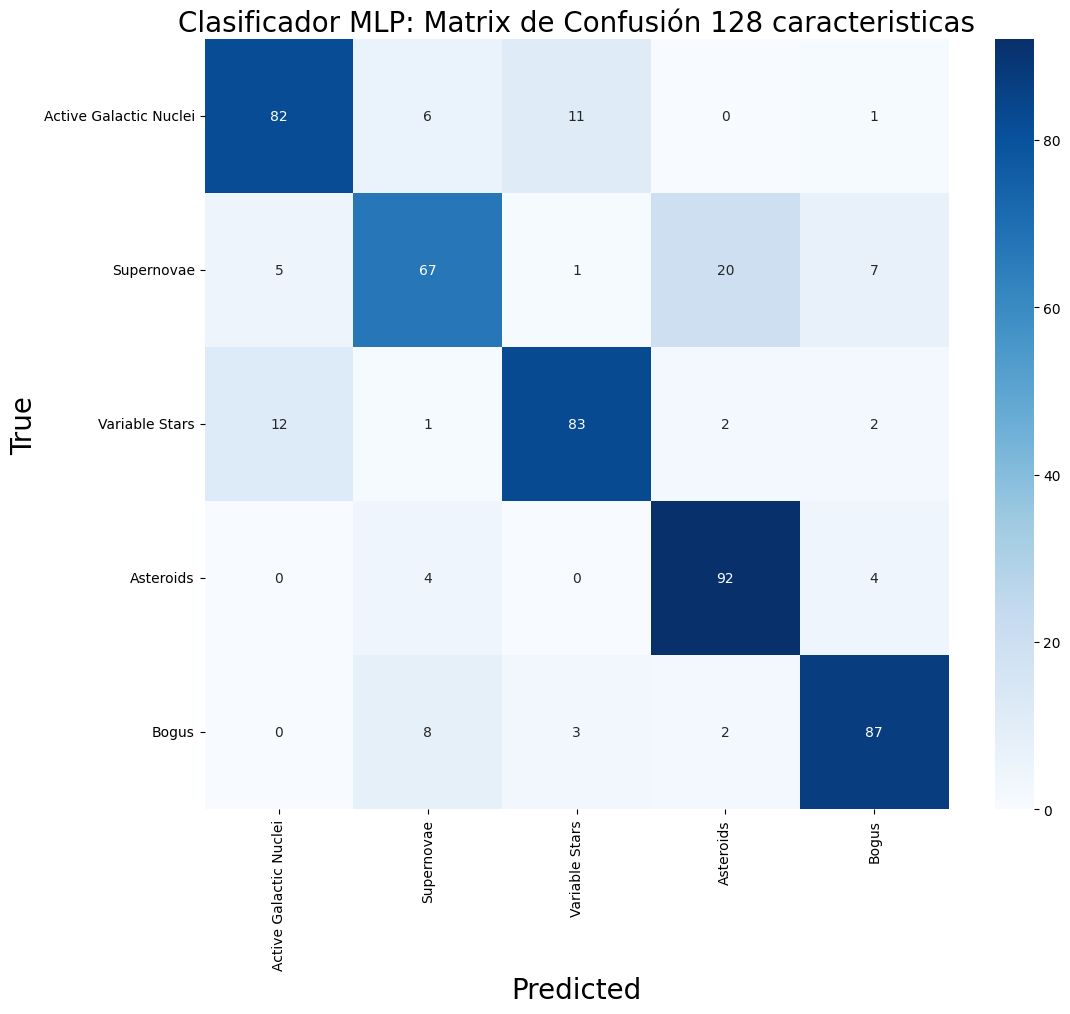

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# X_test=vector_test64
# predict=rbf_svc.predict(X_test)

class_prediction = torch.argmax(y_predicted, axis=1).long()
# https://stackoverflow.com/questions/65618137/confusion-matrix-for-multiple-classes-in-python


# labels = le.classes_
class_names =  ["Active Galactic Nuclei","Supernovae","Variable Stars","Asteroids","Bogus"]

cm = confusion_matrix(y_test, class_prediction)
fig = plt.figure(figsize=(12, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True,cmap="Blues", ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Clasificador MLP: Matrix de Confusión 128 caracteristicas', fontsize=20)

# plt.savefig('ConMat24.png')
plt.show()


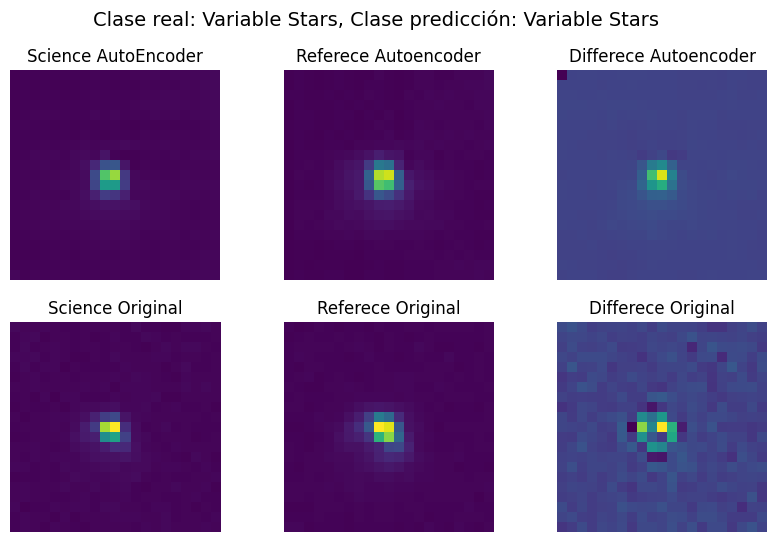

In [54]:
import random
mylist = np.arange(0,500,1)
muestras=random.choices(mylist, k = 1)

# x_test[muestras]
# x_reconstructed[muestras]
figure, axis = plt.subplots(2, 3,figsize=(10,6))
# plt.title("Clase real: "+class_names[int(y_test[muestras].numpy()[0])]+", Clase predicción: "+class_names[int(class_prediction[muestras].numpy()[0])])
plt.suptitle("Clase real: "+class_names[int(y_test[muestras].numpy()[0])]+", Clase predicción: "+class_names[int(class_prediction[muestras].numpy()[0])], fontsize=14)
axis[0, 0].imshow(x_reconstructed[muestras,0][0], cmap='viridis', vmin=0, vmax=1)
axis[0, 0].set_title("Science AutoEncoder")

axis[0, 0].axis('off')
axis[0, 1].axis('off')
axis[1, 0].axis('off')
axis[1, 1].axis('off')

axis[0, 2].axis('off')
axis[1, 2].axis('off')


axis[0, 1].imshow(x_reconstructed[muestras,1][0], cmap='viridis', vmin=0, vmax=1)
axis[0, 1].set_title("Referece Autoencoder")
  
axis[0, 2].imshow(x_reconstructed[muestras,2][0], cmap='viridis', vmin=0, vmax=1)
axis[0, 2].set_title("Differece Autoencoder")
  
axis[1, 0].imshow(x_test[muestras,0][0].numpy(), cmap='viridis', vmin=0, vmax=1)
axis[1, 0].set_title("Science Original")

axis[1, 1].imshow(x_test[muestras,1][0].numpy(), cmap='viridis', vmin=0, vmax=1)
axis[1, 1].set_title("Referece Original")

axis[1, 2].imshow(x_test[muestras,2][0].numpy(), cmap='viridis', vmin=0, vmax=1)
axis[1, 2].set_title("Differece Original")


plt.show()

In [72]:
test_loader = torch.utils.data.DataLoader(my_datatest, batch_size=len(my_datatest), shuffle=False, pin_memory=False)
model.eval()
with torch.no_grad():
    for x_test,y_test in test_loader:
        espacio_latente_test = model.encoder(x_test)

train_loader = torch.utils.data.DataLoader(my_datatrain, batch_size=len(my_datatrain), shuffle=False, pin_memory=False)
with torch.no_grad():
    for x_train,y_train in train_loader:
        espacio_latente_train = model.encoder(x_train)
        
val_loader = torch.utils.data.DataLoader(my_dataval, batch_size=len(my_dataval), shuffle=False, pin_memory=False)
with torch.no_grad():
    for x_val,y_val in val_loader:
        espacio_latente_val = model.encoder(x_val)

In [81]:
validacion_numpy=torch.squeeze(torch.squeeze(espacio_latente_val,2),2).numpy()

In [82]:
train_numpy=torch.squeeze(torch.squeeze(espacio_latente_train,2),2).numpy()

In [83]:
test_numpy=torch.squeeze(torch.squeeze(espacio_latente_test,2),2).numpy()


In [86]:
print(np.shape(train_numpy))
print(np.shape(validacion_numpy))
print(np.shape(test_numpy))


(72710, 128)
(500, 128)
(500, 128)


In [88]:
with open('base.npy', 'wb') as f:
    np.save(f, train_numpy)
    np.save(f, data["Train"]["labels"])
    np.save(f, validacion_numpy)
    np.save(f, data["Validation"]["labels"])
    np.save(f, test_numpy)
    np.save(f, data["Test"]["labels"])


In [2]:
with open('base.npy', 'rb') as f:
    train_numpy = np.load(f)
    train_numpy_label = np.load(f)
    validacion_numpy = np.load(f)
    validacion_numpy_label = np.load(f)
    test_numpy = np.load(f)
    test_numpy_label = np.load(f)


In [3]:
print(np.shape(train_numpy))
print(np.shape(validacion_numpy))
print(np.shape(test_numpy))

(72710, 128)
(500, 128)
(500, 128)


## SVM

In [4]:
# from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# from matplotlib import pyplot as plt
import itertools

In [5]:
from sklearn import svm

rbf_svc = svm.SVC(kernel='rbf')
rbf_svc.fit(train_numpy,train_numpy_label)

SVC()

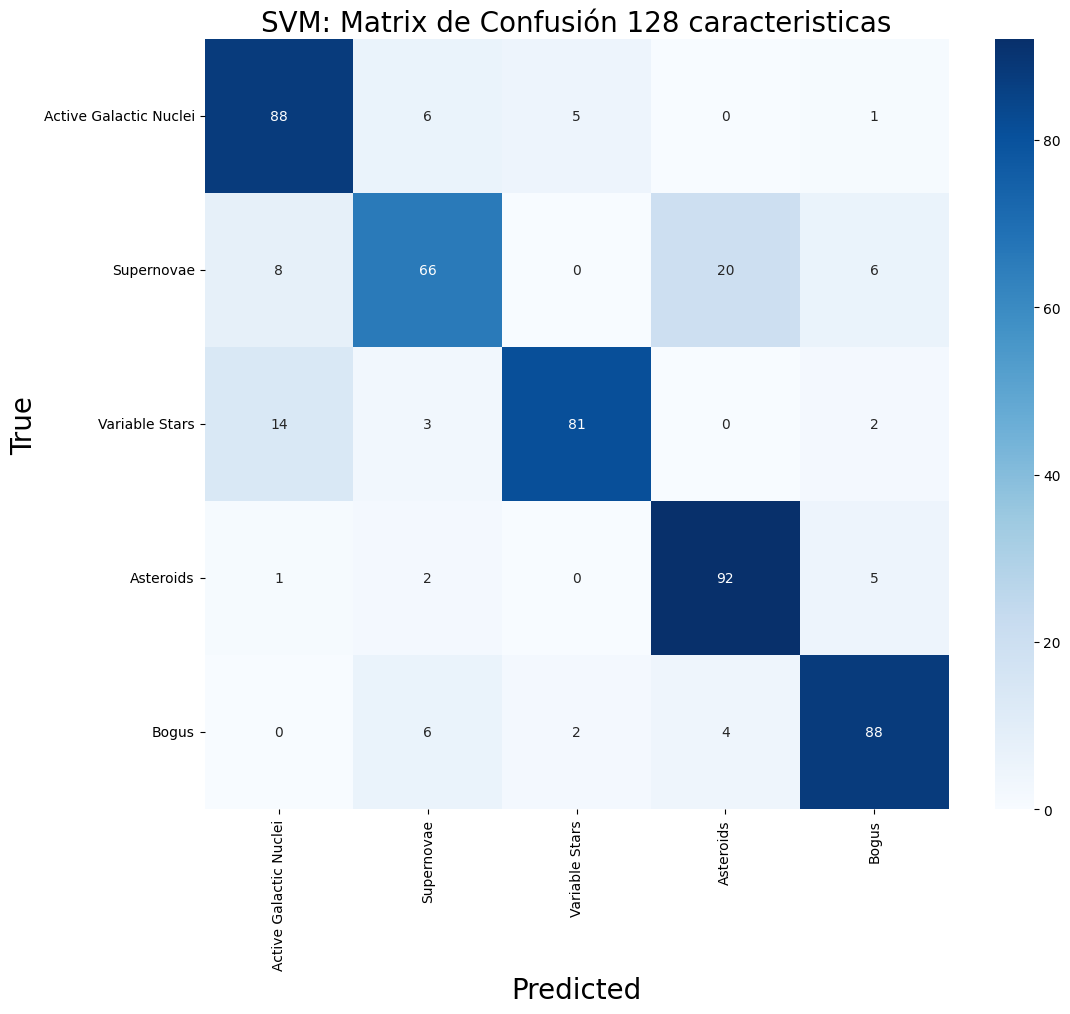

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predict=rbf_svc.predict(test_numpy)

# https://stackoverflow.com/questions/65618137/confusion-matrix-for-multiple-classes-in-python


# labels = le.classes_
class_names =  ["Active Galactic Nuclei","Supernovae","Variable Stars","Asteroids","Bogus"]

cm = confusion_matrix(test_numpy_label, predict)
fig = plt.figure(figsize=(12, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True,cmap="Blues", ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('SVM: Matrix de Confusión 128 caracteristicas', fontsize=20)

# plt.savefig('ConMat24.png')
plt.show()